# Guillaume Chacun

# Assignment 3 ATML 2020

## Unsupervised Feature Learning and Transfer Learning

In many real world applications the amount of labelled training data will be very limited since it is expensive to obtain. Often you will have access to a large amount of unlabelled data however. In this assignment you will explore techniques to leverage large amounts of unlabelled data to learn image representations. These image representations can then be used for novel tasks (e.g., classification) via supervised transfer learning. If the number of labelled examples for the target task is small, unsupervised feature learning can substatially improve the performance on the target task.


### Data

In this assignment you are given two types of training sets: 
- **A large unlabelled training set:** This data will be used to learn a data representation with some unsupervised feature learning method of your choice.
- **A small labelled training set:** This data will be used to perform transfer learning where the previously learned representation is repurposed for image classification.


### Choose an Unsupervised Learning Task

You are free to choose any method to learn features in an unsupervised manner. Possible examples are:
- <u><b>Autoencoders:</b> You can learn features in the encoder of some variant of autoencoders (DAE, VAE, etc...).</u>
- **GAN:** You can use generative adversarial training and transfer features of the discriminator.
- **Self-Supervised Learning:** You can use a pretext task where labels come "for free". Some simple examples are "Rotation Prediction" and "Examplar-CNN".



## Task 1: Prepare data for unsupervised pre-training, supervised transfer learning and evaluation

In [0]:
# if using Google Colaboratory: upload the data as a zip file containing train, test and val folders then run this cell
#!unzip -q data_assignment3.zip -d data_assignment3

In [0]:
unlabelled_train_dir = 'data_assignment3/train_unlabelled'
labelled_train_dir = 'data_assignment3/train'
labelled_validation_dir = 'data_assignment3/val'

In [0]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == 'cuda':
    torch.cuda.current_device()

In [0]:
from tqdm.notebook import tqdm
import glob
import os
from PIL import Image
from torch import Tensor

In [0]:
class LabelledImagesDataset(torch.utils.data.Dataset):
    """Labelled images dataset."""
    
    def __init__(self, root_dir, transforms=None):
        self.images = []
        self.labels = []
        
        print(f'Loading labelled images from the {len(os.listdir(root_dir))} subdirectories of directory: {root_dir}')
        for i, label in tqdm(enumerate(os.listdir(root_dir))): # for each subdirectory containing all images of one specific class
            for img_name in glob.glob(os.path.join(root_dir, label, '*.jpg')): # for each image file in this subdirectory
                with Image.open(img_name) as img:
                    self.images.append(img.copy())
                self.labels.append(int(label))
                
        assert len(self.images) == len(self.labels)
        self.labels = Tensor(self.labels)
        self.transforms = transforms
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transforms:
            image = self.transforms(image)
        return image, self.labels[idx]
        
    def set_transforms(self, transforms):
        self.transforms = transforms

In [0]:
class UnlabelledImagesDataset(torch.utils.data.Dataset):
    """Unlabelled images dataset."""
    
    def __init__(self, root_dir, transforms=None):
        self.images = []
        self.filenames = []
        self._labels = []
        self.transforms = transforms
        
        print(f'Loading unlabelled images from the directory: {root_dir}')
        for img_name in tqdm(glob.glob(os.path.join(root_dir, '*.jpg'))):
                with Image.open(img_name) as img:
                    self.images.append(img.copy())
                try:
                    img_id = int(img_name.split('.')[-2].split('\\')[-1])
                except:
                    img_id = int(img_name.split('.')[-2].split('/')[-1])
                self.filenames.append(img_id)
                self._labels.append(None)
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transforms:
            image = self.transforms(image)
        return image, self.filenames[idx]
    
    def set_label(self, idx, label):
        self._labels[idx] = label
        
    def set_transforms(self, transforms):
        self.transforms = transforms

In [ ]:
# create datasets
unlabelled_train_dataset = UnlabelledImagesDataset(unlabelled_train_dir)
labelled_train_dataset = LabelledImagesDataset(labelled_train_dir)
validation_dataset = LabelledImagesDataset(labelled_validation_dir)

In [8]:
len(unlabelled_train_dataset.images), unlabelled_train_dataset.images[0].size, type(unlabelled_train_dataset.images[0])

(100000, (80, 80), PIL.Image.Image)

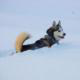

In [9]:
unlabelled_train_dataset.images[0]

## Task 2: Define the CNN architecture

In [0]:
import torch.nn as nn

### AutoEncoder

In [0]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # encoder
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.relu2 = nn.ReLU()

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(24)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, padding=1, stride=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.relu4 = nn.ReLU()

        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.conv5 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3, padding=1, stride=1)
        self.bn5 = nn.BatchNorm2d(48)
        self.relu5 = nn.ReLU()

        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.conv6 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, padding=1, stride=1)
        self.bn6 = nn.BatchNorm2d(48)
        self.relu6 = nn.ReLU()

        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # code
        self.fc1 = nn.Linear(in_features=48*4*4, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=48*4*4)

        # decoder
        self.unpool1 = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.conv_up1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, padding=1, stride=1)
        self.bn_up1 = nn.BatchNorm2d(48)
        self.relu_up1 = nn.ReLU()
        
        self.unpool2 = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.conv_up2 = nn.Conv2d(in_channels=48, out_channels=24, kernel_size=3, padding=1, stride=1)
        self.bn_up2 = nn.BatchNorm2d(24)
        self.relu_up2 = nn.ReLU()
        
        self.unpool3 = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.conv_up3 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, padding=1, stride=1)
        self.bn_up3 = nn.BatchNorm2d(24)
        self.relu_up3 = nn.ReLU()

        self.conv_up4 = nn.Conv2d(in_channels=24, out_channels=12, kernel_size=3, padding=1, stride=1)
        self.bn_up4 = nn.BatchNorm2d(12)
        self.relu_up4 = nn.ReLU()
        
        self.unpool4 = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.conv_up5 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, padding=1, stride=1)
        self.bn_up5 = nn.BatchNorm2d(12)
        self.relu_up5 = nn.ReLU()

        self.conv_up6 = nn.Conv2d(in_channels=12, out_channels=3, kernel_size=3, padding=1, stride=1)

    def forward(self, input):
        # encoder
        output1 = self.relu1(self.bn1(self.conv1(input)))
        output2 = self.relu2(self.bn2(self.conv2(output1)))
        output3, indices1 = self.pool1(output2)
        output4 = self.relu3(self.bn3(self.conv3(output3)))
        output5 = self.relu4(self.bn4(self.conv4(output4)))
        output6, indices2 = self.pool2(output5)
        output7 = self.relu5(self.bn5(self.conv5(output6)))
        output8, indices3 = self.pool3(output7)
        output9 = self.relu6(self.bn6(self.conv6(output8)))
        output10, indices4 = self.pool4(output9)
        
        # code
        output11 = output10.view(-1, 48*4*4)
        output12 = self.fc1(output11)
        output13 = self.fc2(output12)
        output14 = output13.view(-1, 48, 4, 4)

        # decoder
        output15 = self.unpool1(input=output14, indices=indices4, output_size=output9.size())
        output16 = self.relu_up1(self.bn_up1(self.conv_up1(output15)))
        output17 = self.unpool2(input=output16, indices=indices3, output_size=output7.size())
        output18 = self.relu_up2(self.bn_up2(self.conv_up2(output17)))
        output19 = self.unpool3(input=output18, indices=indices2, output_size=output5.size())
        output20 = self.relu_up3(self.bn_up3(self.conv_up3(output19)))
        output21 = self.relu_up4(self.bn_up4(self.conv_up4(output20)))
        output22 = self.unpool4(input=output21, indices=indices1, output_size=output2.size())
        output23 = self.relu_up5(self.bn_up5(self.conv_up5(output22)))
        output24 = self.conv_up6(output23)
        return output24

### Classifier

In [0]:
class ConvNet(nn.Module):
    def __init__(self, default_weights=None):
        super(ConvNet, self).__init__()

        # encoder
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.relu2 = nn.ReLU()

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(24)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, padding=1, stride=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.relu4 = nn.ReLU()

        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.conv5 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3, padding=1, stride=1)
        self.bn5 = nn.BatchNorm2d(48)
        self.relu5 = nn.ReLU()

        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.conv6 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, padding=1, stride=1)
        self.bn6 = nn.BatchNorm2d(48)
        self.relu6 = nn.ReLU()

        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # code
        self.fc1 = nn.Linear(in_features=48*4*4, out_features=512)

        # classification head
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2_head = nn.Linear(in_features=512, out_features=200)

        if default_weights is not None:
            self.load_state_dict(default_weights, strict=False)

    def forward(self, input):
        # encoder
        output1 = self.relu1(self.bn1(self.conv1(input)))
        output2 = self.relu2(self.bn2(self.conv2(output1)))
        output3, indices1 = self.pool1(output2)
        output4 = self.relu3(self.bn3(self.conv3(output3)))
        output5 = self.relu4(self.bn4(self.conv4(output4)))
        output6, indices2 = self.pool2(output5)
        output7 = self.relu5(self.bn5(self.conv5(output6)))
        output8, indices3 = self.pool3(output7)
        output9 = self.relu6(self.bn6(self.conv6(output8)))
        output10, indices4 = self.pool4(output9)
        
        # code
        output11 = output10.view(-1, 48*4*4)
        output12 = self.fc1(output11)

        # classification head
        output13 = self.dropout1(output12)
        output14 = self.fc2_head(output13)
        return output14
        
    def freeze_conv_learning(self):
        # freeze 'encoder' layers (all layers except the 'head')
        for name, param in self.named_parameters():
            if 'head' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

## Task 3. Unsupervised Pre-Training

### Training methods

In [0]:
import time
def train(model, train_dataloader, val_dataloader, optimizer, loss_fn, scheduler, early_stopping,
          n_epochs, is_supervised, start_scheduler_after=0, checkpoint_filename='checkpoint.pt', verbose=2):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    training_since = time.time()
    for epoch in tqdm(range(n_epochs)):
        # train
        train_loss, train_accuracy = train_epoch(model, train_dataloader, 
                                                 optimizer, loss_fn, is_supervised, verbose=verbose)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # validation
        val_loss, val_accuracy = evaluate(model, val_dataloader, loss_fn, is_supervised, verbose=verbose)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # adjust learning rate
        if epoch >= start_scheduler_after:
            scheduler.step(val_loss)

        # early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print('Early stopping')
            break

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load(checkpoint_filename))
    
    # display time elapsed
    time_elapsed = time.time() - training_since
    hours = time_elapsed // 3600
    minutes = (time_elapsed - 3600 * hours) // 60
    print(f'Training took {hours} hour(s) and {minutes} minute(s)')
    return train_losses, train_accuracies, val_losses, val_accuracies

In [0]:
import statistics
def train_epoch(model, train_dataloader, optimizer, loss_fn, is_supervised, verbose=2):
    losses = []
    correct_predictions = 0
    
    model.train() # switch model to training mode
    
    for iteration, data in enumerate(train_dataloader):
        images = data[0].to(device)
        
        # compute outputs
        if is_supervised: # classifier
            bs, ncrops, c, h, w = images.size()
            outputs = model(images.view(-1, c, h, w))
            outputs = outputs.view(bs, ncrops, -1).mean(1) # avg over 10 crops
            labels = data[1].to(device, dtype=torch.int64)
            loss = loss_fn(outputs, labels)
            correct_predictions += (outputs.argmax(dim=1) == labels).sum().item()
            
        else: # autoencoder
            outputs = model(images)
            loss = loss_fn(outputs, images)
        
        # gradient & optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if verbose>=2 and iteration % 16 == 0:
            print('Training iteration {}: loss {:.4f}'.format(iteration, loss.item()))
            
    # compute & print statistics
    average_loss = statistics.mean(losses)
    accuracy = 100.0 * correct_predictions / len(train_dataloader.dataset) if is_supervised else None
    if verbose>=1:
        if is_supervised:
            print(f'Train average loss: {round(average_loss,4)}, accuracy: {round(accuracy,3)}')
        else:
            print(f'Train average loss: {round(average_loss,4)}')
    return average_loss, accuracy

In [0]:
def evaluate(model, val_dataloader, loss_fn, is_supervised, verbose=2):
    losses = []
    correct_predictions = 0
    
    model.eval() # switch model to test mode
    
    with torch.no_grad():
        for data in val_dataloader:
            images = data[0].to(device)
        
            # compute outputs
            if is_supervised: # classifier
                bs, ncrops, c, h, w = images.size()
                outputs = model(images.view(-1, c, h, w))
                outputs = outputs.view(bs, ncrops, -1).mean(1) # avg over 10 crops
                labels = data[1].to(device, dtype=torch.int64)
                loss = loss_fn(outputs, labels)
                correct_predictions += (outputs.argmax(dim=1) == labels).sum().item()

            else: # autoencoder
                outputs = model(images)
                loss = loss_fn(outputs, images)
                
            losses.append(loss.item())

    # compute & print statistics
    average_loss = statistics.mean(losses)
    accuracy = 100.0 * correct_predictions / len(val_dataloader.dataset) if is_supervised else None
    if verbose>=1:
        if is_supervised:
            print(f'Validation average loss: {round(average_loss,4)}, accuracy: {round(accuracy,3)}')
        else:
            print(f'Validation average loss: {round(average_loss,4)}')
    return average_loss, accuracy

### Utils

In [0]:
def plot_ae_output(model, images, nb_images, loss_fn):
    inverse_normalize = transforms.Normalize(mean=(-0.5/0.5,), std=(1/0.5,))
    images = images.to(device)

    model.eval() # switch model to test mode
    
    fig, axs = plt.subplots(nb_images, 2, figsize=(16,16))
    fig.suptitle('True and fake examples from autoencoder', fontsize=16)
    with torch.no_grad():
        outputs = model(images)
        loss = loss_fn(outputs, images)

        for i, (image, output) in enumerate(zip(images, outputs)):
            image = inverse_normalize(image)
            image = image.permute(1, 2, 0).cpu().numpy()
            axs[i][0].imshow(image)
            axs[i][0].title.set_text(f'True')

            output = inverse_normalize(output)
            output = output.permute(1, 2, 0).cpu().numpy()
            axs[i][1].imshow(output)
            axs[i][1].title.set_text(f'Fake')
    print("Loss on those %i image(s): %.3f" % (nb_images, loss))
    plt.show()

In [0]:
import matplotlib.pyplot as plt
def plot_training_curves(train_losses, train_accuracies=[None], val_losses=[None], val_accuracies=[None]):
    n_epochs = len(train_losses)
    plot_val_losses, plot_train_accuracies, plot_val_accuracies = val_losses is not None, train_accuracies[0] is not None, val_accuracies[0] is not None
    nb_plots = 2 if plot_train_accuracies or plot_val_accuracies else 1
    fig, axs = plt.subplots(ncols=nb_plots, figsize=(15,6))
    fig.suptitle('Learning curve(s)', fontsize=16)
    if nb_plots == 1:
        axs = np.array([axs])

    # losses
    axs[0].plot(np.arange(n_epochs), train_losses)
    if plot_val_losses:
        axs[0].plot(np.arange(n_epochs), val_losses)
        axs[0].legend(['train_loss', 'val_loss'])
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss value')
    axs[0].title.set_text('Train/val loss' if plot_val_losses else 'Train loss')

    # accuracies
    if plot_train_accuracies:
        axs[1].plot(np.arange(n_epochs), train_accuracies)
    if plot_val_accuracies:
        axs[1].plot(np.arange(n_epochs), val_accuracies)
        axs[1].legend(['train_acc', 'val_acc'])
    if plot_train_accuracies or plot_val_accuracies:
        axs[1].set_xlabel('epoch')
        axs[1].set_ylabel('accuracy')
        axs[1].title.set_text('Train/val accuracy' if plot_val_accuracies else 'Train accuracy')

In [0]:
def print_training_results(train_losses, train_accuracies, val_losses, val_accuracies, print_accuracies=True):
    n_epochs = len(train_losses)
    print(f'Average loss & accuracy after last training epoch (n° {n_epochs}):')
    if print_accuracies:
        print(f'Train average loss: {round(train_losses[-1], 4)}, accuracy: {round(train_accuracies[-1], 4)}')
        print(f'Validation average loss: {round(val_losses[-1], 4)}, accuracy: {round(val_accuracies[-1], 4)}')
    else:
        print(f'Train average loss: {round(train_losses[-1], 4)}')
        print(f'Validation average loss: {round(val_losses[-1], 4)}')

### Initialization

In [0]:
# initialize parameters, model, optimizer and loss function
import numpy as np
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from EarlyStopping import EarlyStopping

# set parameters
ae_n_epochs = 90
ae_learning_rate = 1e-3
ae_weight_decay = 1e-5
ae_batch_size = 128

# initialize model
autoencoder = AutoEncoder()
autoencoder = autoencoder.to(device)

# initialize optimizer and loss function
ae_optimizer = Adam(autoencoder.parameters(), lr=ae_learning_rate, weight_decay=ae_weight_decay)
ae_loss_fn = nn.MSELoss()
ae_scheduler = ReduceLROnPlateau(ae_optimizer, patience=7, cooldown=5, threshold=1e-4, min_lr=1e-6, verbose=True)

ae_checkpoint_filename = 'ae_checkpoint.pt'
ae_early_stopping = EarlyStopping(checkpoint_filename=ae_checkpoint_filename, patience=15, delta=1e-5, verbose=True)

In [0]:
# data augmentation for autoencoder
from torchvision import transforms
ae_train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8), 
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

ae_test_transforms = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

unlabelled_train_dataset.set_transforms(ae_train_transforms)
validation_dataset.set_transforms(ae_test_transforms)

In [0]:
# create dataloader
from torch.utils.data import DataLoader

unlabelled_train_dataloader = DataLoader(unlabelled_train_dataset, batch_size=ae_batch_size, shuffle=True)
ae_val_dataloader = DataLoader(validation_dataset, batch_size=ae_batch_size, shuffle=False)

### Autoencoder's training

In [0]:
# train the model
ae_training_info = train(autoencoder, unlabelled_train_dataloader, ae_val_dataloader, 
                         ae_optimizer, ae_loss_fn, ae_scheduler, ae_early_stopping,
                         ae_n_epochs, is_supervised=False, 
                         start_scheduler_after=5, checkpoint_filename=ae_checkpoint_filename, verbose=2)

Average loss & accuracy after last training epoch (n° 90):
Train average loss: 0.0065
Validation average loss: 0.0082


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 0.006


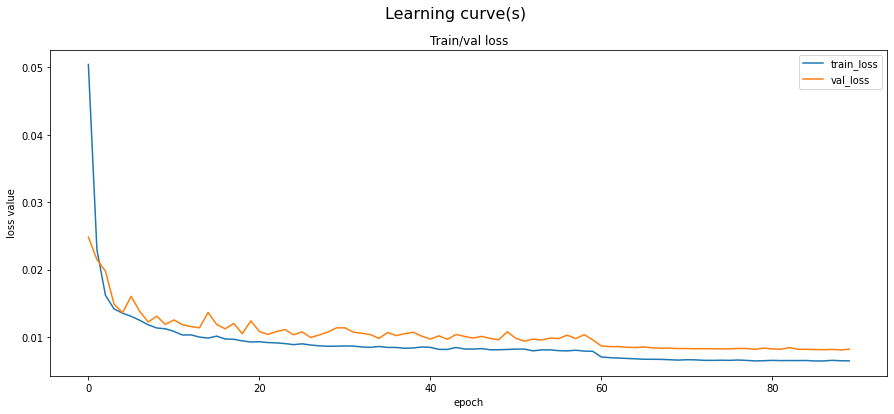

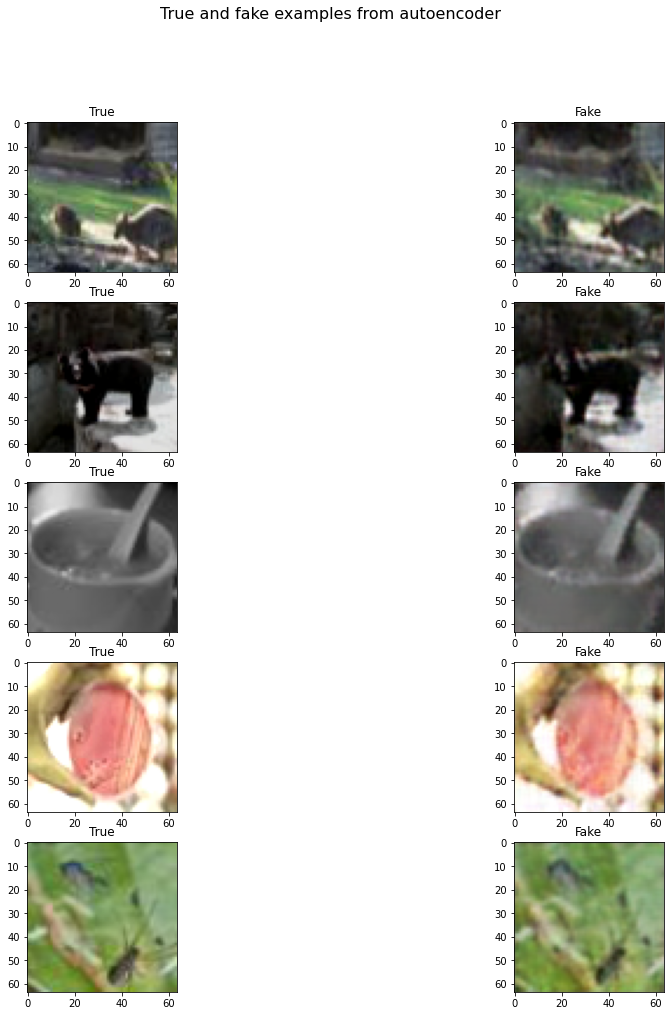

In [52]:
# print training info & plot training curves
print_training_results(*ae_training_info, print_accuracies=False)
plot_training_curves(*ae_training_info)

import random
nb_images = 5
rdm_idx = random.randint(0, ae_batch_size-nb_images)
plot_ae_output(autoencoder, next(iter(unlabelled_train_dataloader))[0][rdm_idx:rdm_idx+nb_images], nb_images, ae_loss_fn)

### Restore autoencoder's weights

In [0]:
autoencoder_weights = torch.load(ae_checkpoint_filename)

In [24]:
autoencoder.load_state_dict(autoencoder_weights.copy())
_ = evaluate(autoencoder, ae_val_dataloader, ae_loss_fn, is_supervised=False, verbose=1)

Validation average loss: 0.0081


(0.008091871888609603, None, [])

## Task 4. Transfer Learning Experiments

In [0]:
# set parameters
cn_n_epochs = 200
cn_learning_rate = 1e-3
cn_weight_decay = 1e-4
cn_batch_size = 128
cn_min_lr = 1e-8

In [0]:
# data augmentation for convnets
normalize = transforms.Normalize(mean=(0.5,), std=(0.5,))
cn_train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(80),
    transforms.RandomRotation(10),
    transforms.RandomApply([transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.TenCrop(64),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
    transforms.Lambda(lambda crops: torch.stack([normalize(crop) for crop in crops]))
])

cn_test_transforms = transforms.Compose([
    transforms.TenCrop(64),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
    transforms.Lambda(lambda crops: torch.stack([normalize(crop) for crop in crops]))
])

labelled_train_dataset.set_transforms(cn_train_transforms)
validation_dataset.set_transforms(cn_test_transforms)

In [0]:
# create dataloaders
labelled_train_dataloader = DataLoader(labelled_train_dataset, batch_size=cn_batch_size, shuffle=True)
val_dataloader = DataLoader(validation_dataset, batch_size=cn_batch_size, shuffle=False)

### Fixed Features
Initialize the first $k$ layers with the parameters learned in Task 3 and randomly initialize the layers of the classification head. ***Train only the layers of the classification head!***

In [0]:
# initialize model
convnet1 = ConvNet(default_weights=autoencoder_weights.copy()) # initialize the first k layers with weights from task 3
convnet1.freeze_conv_learning() # train only the layers of the classification head 
convnet1 = convnet1.to(device)

# initialize optimizer and loss function
cn1_optimizer = Adam(filter(lambda p: p.requires_grad, convnet1.parameters()), lr=cn_learning_rate, weight_decay=cn_weight_decay)
cn1_loss_fn = nn.CrossEntropyLoss()
cn1_scheduler = ReduceLROnPlateau(cn1_optimizer, patience=12, cooldown=5, threshold=1e-4, min_lr=cn_min_lr, verbose=True)

cn1_checkpoint_filename = 'cn1_checkpoint.pt'
cn1_early_stopping = EarlyStopping(checkpoint_filename=cn1_checkpoint_filename, patience=20, delta=1e-5, verbose=True)

In [ ]:
# train the model
training_info1 = train(convnet1, 
                       labelled_train_dataloader, val_dataloader, 
                       cn1_optimizer, cn1_loss_fn, cn1_scheduler, cn1_early_stopping,
                       cn_n_epochs, is_supervised=True,
                       start_scheduler_after=5, checkpoint_filename=cn1_checkpoint_filename, verbose=1)

Average loss & accuracy after last training epoch (n° 200):
Train average loss: 5.1, accuracy: 3.975
Validation average loss: 5.0308, accuracy: 6.5


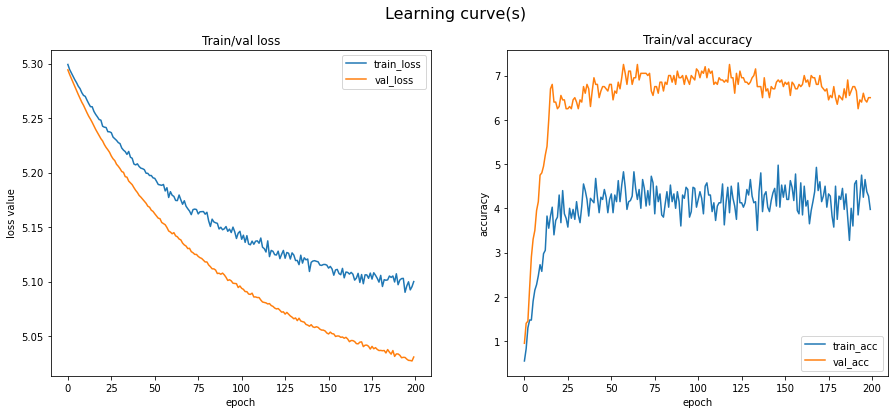

In [30]:
# print training info & plot training curves
print_training_results(*training_info1)
plot_training_curves(*training_info1)

In [0]:
# clear memory
convnet1 = cn1_optimizer = None
del convnet1
del cn1_optimizer
torch.cuda.empty_cache()

### Finetuned Features
Initialize the first $k$ layers with the parameters learned in Task 3 and randomly initialize the layers of the classification head. ***Train all the layers!***

In [0]:
# initialize model
convnet2 = ConvNet(default_weights=autoencoder_weights.copy()) # initialize the first k layers with weights from task 3
convnet2 = convnet2.to(device)

# initialize optimizer and loss function
cn2_optimizer = Adam(convnet2.parameters(), lr=cn_learning_rate, weight_decay=cn_weight_decay)
cn2_loss_fn = nn.CrossEntropyLoss()
cn2_scheduler = ReduceLROnPlateau(cn2_optimizer, patience=12, cooldown=5, threshold=5e-5, min_lr=cn_min_lr, verbose=True)

cn2_checkpoint_filename = 'cn2_checkpoint.pt'
cn2_early_stopping = EarlyStopping(checkpoint_filename=cn2_checkpoint_filename, patience=20, delta=1e-5, verbose=True)

In [0]:
# train the model
training_info2 = train(convnet2, 
                       labelled_train_dataloader, val_dataloader, 
                       cn2_optimizer, cn2_loss_fn, cn2_scheduler, cn2_early_stopping,
                       cn_n_epochs, is_supervised=True,
                       start_scheduler_after=5, checkpoint_filename=cn2_checkpoint_filename, verbose=1)

Average loss & accuracy after last training epoch (n° 142):
Train average loss: 3.6574, accuracy: 21.6
Validation average loss: 4.292, accuracy: 15.05


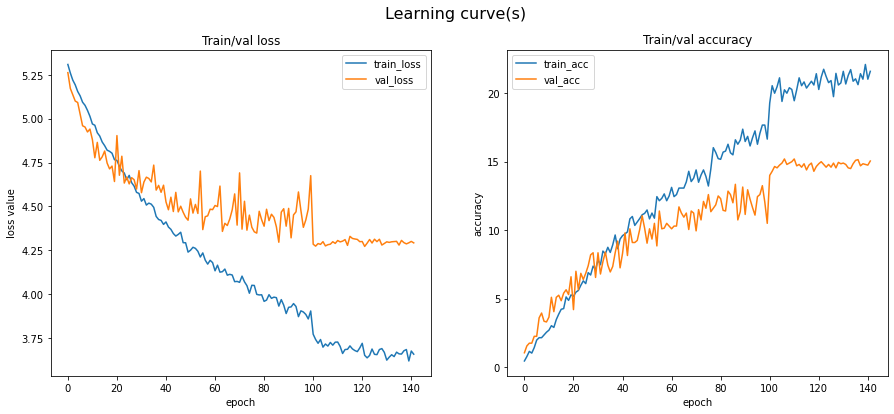

In [42]:
# print training info & plot training curves
print_training_results(*training_info2)
plot_training_curves(*training_info2)

In [0]:
# clear memory
convnet2 = cn2_optimizer = None
del convnet2
del cn2_optimizer
torch.cuda.empty_cache()

### Random Features Fixed
Randomly initialize all the layers for the classification task (do not use parameters learned in Task 3). ***Train only the layers of the classification head!***

In [0]:
# initialize model
convnet3 = ConvNet()
convnet3.freeze_conv_learning() # train only the layers of the classification head 
convnet3 = convnet3.to(device)

# initialize optimizer and loss function
cn3_optimizer = Adam(convnet3.parameters(), lr=cn_learning_rate, weight_decay=cn_weight_decay)
cn3_loss_fn = nn.CrossEntropyLoss()
cn3_scheduler = ReduceLROnPlateau(cn3_optimizer, patience=7, cooldown=5, threshold=1e-4, min_lr=cn_min_lr, verbose=True)

cn3_checkpoint_filename = 'cn3_checkpoint.pt'
cn3_early_stopping = EarlyStopping(checkpoint_filename=cn3_checkpoint_filename, patience=15, delta=1e-5, verbose=True)

In [ ]:
# train the model
training_info3 = train(convnet3, 
                       labelled_train_dataloader, val_dataloader, 
                       cn3_optimizer, cn3_loss_fn, cn3_scheduler, cn3_early_stopping,
                       cn_n_epochs, is_supervised=True,
                       start_scheduler_after=5, checkpoint_filename=cn3_checkpoint_filename, verbose=1)

Average loss & accuracy after last training epoch (n° 120):
Train average loss: 4.9455, accuracy: 4.575
Validation average loss: 4.8995, accuracy: 4.9


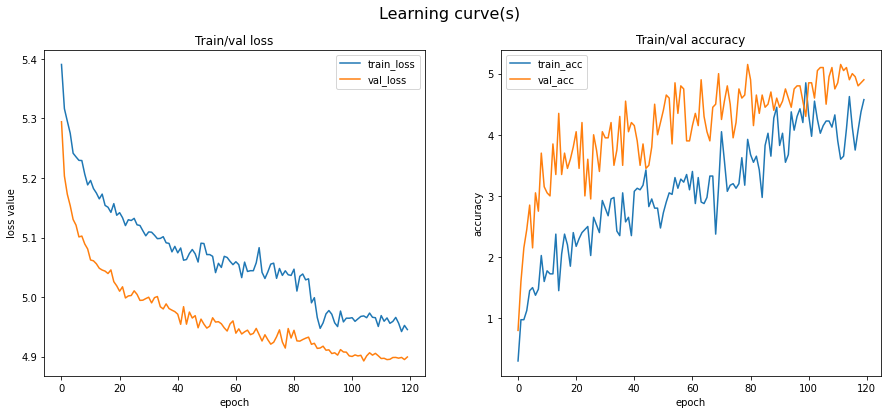

In [34]:
# print training info & plot training curves
print_training_results(*training_info3)
plot_training_curves(*training_info3)

In [0]:
# clear memory
convnet3 = cn3_optimizer = None
del convnet3
del cn3_optimizer
torch.cuda.empty_cache()

### Random Features Finetuned
Randomly initialize all the layers for the classification task (do not use parameters learned in Task 3). ***Train all the layers!***

In [0]:
# initialize model
convnet4 = ConvNet()
convnet4 = convnet4.to(device)

# initialize optimizer and loss function
cn4_optimizer = Adam(convnet4.parameters(), lr=cn_learning_rate, weight_decay=cn_weight_decay)
cn4_loss_fn = nn.CrossEntropyLoss()
cn4_scheduler = ReduceLROnPlateau(cn4_optimizer, patience=7, cooldown=5, threshold=1e-4, min_lr=cn_min_lr, verbose=True)

cn4_checkpoint_filename = 'cn4_checkpoint.pt'
cn4_early_stopping = EarlyStopping(checkpoint_filename=cn4_checkpoint_filename, patience=15, delta=1e-5, verbose=True)

In [ ]:
# train the model
training_info4 = train(convnet4, 
                       labelled_train_dataloader, val_dataloader, 
                       cn4_optimizer, cn4_loss_fn, cn4_scheduler, cn4_early_stopping,
                       cn_n_epochs, is_supervised=True,
                       start_scheduler_after=5, checkpoint_filename=cn4_checkpoint_filename, verbose=1)

Average loss & accuracy after last training epoch (n° 85):
Train average loss: 3.758, accuracy: 19.575
Validation average loss: 4.3833, accuracy: 14.1


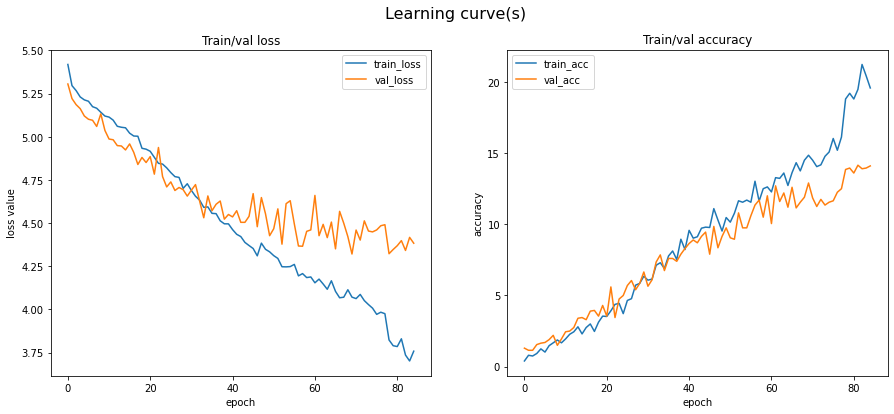

In [38]:
# print training info & plot training curves
print_training_results(*training_info4)
plot_training_curves(*training_info4)

In [0]:
# clear memory
convnet4 = cn4_optimizer = None
del convnet4
del cn4_optimizer
torch.cuda.empty_cache()

### Report - transfer learning's results summary

<div style="width:100%; text-align:center; margin: 0 auto;">
<table style="display:inline-block;">
    <tr><td colspan="4" style="text-align:center; border-bottom:1px solid gray"><u><b style="font-size:14px">Train loss / accuracy</b></u></td></tr>
    <tr><td colspan="2" style="background-color:#F5F5F5"></td><th colspan="2">Init. with encoder's weights</th></tr>
    <tr><td colspan="2" style="background-color:#F5F5F5"></td><th>Yes</th><th>No</th></tr>
    <tr><th rowspan="2">Freeze encoder's layers</th><th>Yes</th>
        <td>(1) 5.100 / 3.97%</td>
        <td>(3) 4.945 / 4.57%</td>
    </tr>
    <tr><th>No</th>
        <td style="color:green"><i>(2) 3.657 / 21.60%</i></td>
        <td>(4) 3.758 / 19.57%</td>
    </tr>
</table>

<table style="display:inline-block; margin-left:50px;">
    <tr><td colspan="4" style="text-align:center; border-bottom:1px solid gray"><u><b style="font-size:14px">Validation loss / accuracy</b></u></td></tr>
    <tr><td colspan="2" style="background-color:#F5F5F5"></td><th colspan="2">Init. with encoder's weights</th></tr>
    <tr><td colspan="2" style="background-color:#F5F5F5"></td><th>Yes</th><th>No</th></tr>
    <tr><th rowspan="2">Freeze encoder's layers</th><th>Yes</th>
        <td>(1) 5.030 / 6.50%</td>
        <td>(3) 4.899 / 4.90%</td>
    </tr>
    <tr><th>No</th>
        <td style="color:green"><i>(2) 4.292 / 15.05%</i></td>
        <td>(4) 4.383 / 14.10%</td>
    </tr>
</table>
</div>

<p style="text-align:justify">
    The best performing model is the ConvNet2. It is initialized with the encoder's weights and all layers are trainable. An accuracy of 15.05% is obtained on the validation set for 21.60 on the training set.
    Follows the ConvNet4, 1 and 3. Therefore, initializing the weights with those of the encoder gives better results than with random initialization.
</p>

## Task 5. Competition time!

### Predict on test set

In [0]:
import pandas as pd
# test dataset / dataloader
test_dataset = UnlabelledImagesDataset('data_assignment3/test', transforms=cn_test_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=cn_batch_size, shuffle=False)

# load best models
final_models = []
for model_checkpoint in ['cn2_checkpoint-top1.pt',
                         'cn2_checkpoint-top2.pt',
                         'cn2_checkpoint-top3.pt',
                         ]:
    final_model = ConvNet()
    final_model = final_model.to(device)
    final_model.load_state_dict(torch.load(model_checkpoint))
    final_model.eval()
    final_models.append(final_model)

nb_models = len(final_models)
outputs_list = []

# make predictions
with torch.no_grad():
    for data in test_dataloader: # data: (images,filenames)
        images = data[0].to(device)
        bs, ncrops, c, h, w = images.size()
        batch_models_outputs = []
        for model in final_models:
            outputs = model(images.view(-1, c, h, w))
            batch_models_outputs.append(outputs.view(bs, ncrops, -1).mean(1)) # avg over 10 crops

        avg_outputs = torch.stack(batch_models_outputs, dim=2)
        avg_outputs = avg_outputs.mean(2) # avg over models

        images_id = data[1].to(device, dtype=torch.int64)

        outputs_list += [(image_id, output.argmax()) for (image_id, output) in zip(images_id, avg_outputs)]

# create predictions' file
predictions = [(image_id.item(), output.item()) for image_id, output in outputs_list]
predictions = sorted(predictions, key=lambda x: x[0])
df_predictions = pd.DataFrame(predictions, columns=["id", "label"])
df_predictions.to_csv('./Chacun.csv', index=False)
print('Predictions saved!')

### Report - Final model used

<p style="text-align:justify">
ConvNet2 is the architecture used for the Kaggle competition. <br/><br/>The first part is exactly the same architecture as the autoencoder's encoder. It is formed of six convolutional layers, four max-pooling layers and one linear layer (fully connected). The output is a latent vector of 512 dimensions. Each convolutional layer is formed of the convolution (with a 3x3 kernel), some batch normalization and a ReLU activation. The max-pooling layers have 2x2 kernels. <br/>The second part of the classifier is the "head". It consists of a simple dropout layer (p=0.5) followed by a fully connected layer which maps the 512 representation vectors to the 200 classes. <br/><br/>
<img src="./images/convnet_architecture_table.png" alt="ConvNet2 architecture"><i style="display: block; text-align: center; font-size: 11px;">ConvNet2 architecture used for the Kaggle conpetition.</i><br/><br/>First, the autoencoder has been trained on the unlabelled data. Its architecture is composed of the previously described encoder followed by its exact symmetry (the decoder). The final mean-squared error computed on the validation set is 0.008.<br/><br/>The encoder's weights are saved and restored in the classifier. Only its head is randomly initialized. All layers may be fine-tuned.<br/><br/>Heavy data augmentation is used to compensate for the small labelled dataset. Each image is randomly resized with different aspect ratio and rotated. Their brightness, contrast and saturation are also randomly tweaked. Approximately one image out of 5 five will be converted to grayscale. Finally, the resulting image is croped into four corners, the central crop plus their horizontally flipped version. They are all transformed to tensors and normalized.<br/><br/>The classifier predicts the class of the ten images independently and averages the results to find the most probable class of the whole image.<br/><br/>As described in section 2.5.5, this classifier alone reaches 15.05% accuracy on the validation set and 15.02% on the test set (Kaggle) after 46 minutes of training on the Google Colaboratory's GPUs.<br/><br/>To improve those results, three classifiers (ConvNet2 architectures) which obtained similar results independently (~15%) were used together. Each one computes the classes likelihood probability for each image. Those are then averaged between the classifiers. This method allows to combine the strengths of the models and obtains better accuracy on the validation set (15.9%) and the Kaggle's test set (16.6%).
</p>